# SVD++

We first install the necessary packages.

In [ ]:
pip install scikit-surprise

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 154.4/154.4 kB 4.5 MB/s eta 0:00:00
  Installing build dependencies ... done
  Getting requirements to build wheel ... done
  Preparing metadata (pyproject.toml) ... done
  Created wheel for scikit-surprise: filename=scikit_surprise-1.1.4-cp310-cp310-linux_x86_64.whl size=2357289 sha256=ef4c2369be5278197dede32066538c59c0f3002f90ebde73e7c283223146953d
  Stored in directory: /root/.cache/pip/wheels/4b/3f/df/6acbf0a40397d9bf3ff97f582cc22fb9ce66adde75bc71fd54
Successfully built scikit-surprise


In [ ]:
import pandas as pd
import numpy as np

## Temporal Splitting on Newest Data

We split the data temporally. In other words, we first find the 180000 most recent ratings. We then reserve the newest 20000 of the 180000 ratings as the test set. Among the remaining 160000, we randomly split them into a training set of 80000 that is to be used for each of the individual models, and another training set of 80000 that is to be used for the ensemble model.

In [ ]:
full = pd.read_csv('test.csv').drop(columns=['Unnamed: 0'])[-180000:] # despite its name, test.csv actually contains the 1000000 newest ratings sorted by rating date from the oldest to the newest
full # full contains the 180000 newest ratings

,movie_id,user_id,rating,date,Year,Title
20000,17147,427460,4,2005-12-29,1996,She's the One
20001,4353,1605111,5,2005-12-29,2002,Curb Your Enthusiasm: Season 3
20002,3923,13949,3,2005-12-29,1997,Beverly Hills Ninja
20003,6874,200779,3,2005-12-29,2003,The Cooler
20004,12582,851475,4,2005-12-29,2003,Mystic River
...,...,...,...,...,...,...
199995,8993,2183787,4,2005-12-31,2005,Family Guy Presents: Stewie Griffin: The Untol...
199996,7430,258170,4,2005-12-31,2001,Six Feet Under: Season 1
199997,8467,1534359,5,2005-12-31,1996,Eraser
199998,10168,2543295,2,2005-12-31,2003,The League of Extraordinary Gentlemen


In [ ]:
train_full = full[:160000] # the 160000 ratings used in training
train_full

,movie_id,user_id,rating,date,Year,Title
20000,17147,427460,4,2005-12-29,1996,She's the One
20001,4353,1605111,5,2005-12-29,2002,Curb Your Enthusiasm: Season 3
20002,3923,13949,3,2005-12-29,1997,Beverly Hills Ninja
20003,6874,200779,3,2005-12-29,2003,The Cooler
20004,12582,851475,4,2005-12-29,2003,Mystic River
...,...,...,...,...,...,...
179995,13629,1318034,4,2005-12-31,1951,Alice in Wonderland
179996,17324,1719503,4,2005-12-31,2005,Hitch
179997,17324,22846,5,2005-12-31,2005,Hitch
179998,3860,1799620,2,2005-12-31,2003,Bruce Almighty


In [ ]:
test = full[-20000:] # the 20000 ratings used for testing
test

,movie_id,user_id,rating,date,Year,Title
180000,16445,1250138,2,2005-12-31,2003,"House of 1,000 Corpses"
180001,6850,714682,1,2005-12-31,2005,Lords of Dogtown
180002,3441,859907,2,2005-12-31,2005,Kicking & Screaming
180003,10748,2373473,3,2005-12-31,1987,Hamburger Hill
180004,5496,1678873,2,2005-12-31,2004,"I, Robot"
...,...,...,...,...,...,...
199995,8993,2183787,4,2005-12-31,2005,Family Guy Presents: Stewie Griffin: The Untol...
199996,7430,258170,4,2005-12-31,2001,Six Feet Under: Season 1
199997,8467,1534359,5,2005-12-31,1996,Eraser
199998,10168,2543295,2,2005-12-31,2003,The League of Extraordinary Gentlemen


In [ ]:
from sklearn.model_selection import train_test_split

# Randomly split the 160000 training data into a set used for individual models and another set used for the ensemble model
train, ensemble_train = train_test_split(train_full, test_size=0.5, random_state=42)
print(len(train))
print(len(ensemble_train))

80000
80000


In [ ]:
train # "train" is used for training each of the individual models

,movie_id,user_id,rating,date,Year,Title
72231,15582,1386463,3,2005-12-29,2002,Sweet Home Alabama
75364,9087,1380250,3,2005-12-29,1992,Hero
53303,16793,2188505,3,2005-12-29,1973,The Exorcist
47730,5762,1109774,2,2005-12-29,2000,Almost Famous
136959,10072,1067658,3,2005-12-30,2004,Prime Suspect 6
...,...,...,...,...,...,...
139879,2457,71480,2,2005-12-30,2004,A Cinderella Story
123694,11089,2300374,4,2005-12-30,2001,"Monsters, Inc."
151932,6134,2610903,4,2005-12-30,2004,Collateral
166867,5762,1784540,4,2005-12-31,2000,Almost Famous


In [ ]:
ensemble_train # "ensemble_train" is used for training the ensemble model

,movie_id,user_id,rating,date,Year,Title
140476,17574,2475007,5,2005-12-30,1996,Eye for an Eye
52693,14312,583131,4,2005-12-29,1993,Jurassic Park
99958,10747,1795937,4,2005-12-30,1987,Can't Buy Me Love
96366,4306,617075,4,2005-12-30,1999,The Sixth Sense
102343,4302,1999688,5,2005-12-30,1982,An Officer and a Gentleman
...,...,...,...,...,...,...
141665,191,1965579,5,2005-12-30,2003,X2: X-Men United
142463,1104,1498526,3,2005-12-30,1983,Krull
68961,2153,1916203,3,2005-12-29,1993,Free Willy
151628,15788,1988882,3,2005-12-30,2003,Matchstick Men


In [ ]:
len(train['movie_id'].unique()) # number of movies in training set for individual models

8070

In [ ]:
len(train['user_id'].unique()) # number of users in training set for individual models

16062

#### Further Split of Train and Validation Sets

We use the validation set approach to select the hyperparameters for each of the individual models. In this case, we further divide the training set for the individual models into a non-validation set of size 64000 (used for training in the validation set approach) and a validation set of size 16000 (used for testing in the validation set approach).

In [ ]:
non_validation = train[:64000]
non_validation # used for training when selecting hyperparameters

,movie_id,user_id,rating,date,Year,Title
72231,15582,1386463,3,2005-12-29,2002,Sweet Home Alabama
75364,9087,1380250,3,2005-12-29,1992,Hero
53303,16793,2188505,3,2005-12-29,1973,The Exorcist
47730,5762,1109774,2,2005-12-29,2000,Almost Famous
136959,10072,1067658,3,2005-12-30,2004,Prime Suspect 6
...,...,...,...,...,...,...
30015,7879,40960,3,2005-12-29,2002,Super Troopers
80369,6274,240400,3,2005-12-30,1990,The Hunt for Red October
55706,16796,2026731,5,2005-12-29,2001,Brian's Song
45223,357,649154,4,2005-12-29,2003,House of Sand and Fog


In [ ]:
validation = train[64000:]
validation # used for testing when selecting hyperparameters

,movie_id,user_id,rating,date,Year,Title
31584,6833,793778,5,2005-12-29,1995,Billy Madison
161832,16784,1663055,3,2005-12-31,2005,The Sisterhood of the Traveling Pants
63677,5496,2397099,4,2005-12-29,2004,"I, Robot"
70478,10906,1208781,2,2005-12-29,2004,Cellular
148826,17154,1489446,5,2005-12-30,1993,Philadelphia
...,...,...,...,...,...,...
139879,2457,71480,2,2005-12-30,2004,A Cinderella Story
123694,11089,2300374,4,2005-12-30,2001,"Monsters, Inc."
151932,6134,2610903,4,2005-12-30,2004,Collateral
166867,5762,1784540,4,2005-12-31,2000,Almost Famous


## compute_rmse Function

We define a compute_rmse function that takes in the predicted output and actual output, so that we can conveniently compute the RMSE of our predictions.

In [ ]:
# Takes in two NumPy arrays
def compute_rmse(predicted, actual):
    return np.sqrt(np.mean((predicted - actual) * (predicted - actual)))

## Model Training and Testing

We take advantage of the SVD++ implementation in the surprise package. We first prepare the training and testing data into a form usable by surprise's SVD++.

In [ ]:
from surprise import reader, Dataset, Trainset, SVDpp
from surprise.model_selection import train_test_split
from surprise.dataset import DatasetAutoFolds
ratings_reader = reader.Reader(rating_scale=(1,5))
train_dset = Dataset.load_from_df(train[['user_id', 'movie_id', 'rating']], ratings_reader)
test_dset = Dataset.load_from_df(test[['user_id', 'movie_id', 'rating']], ratings_reader)
trainset = DatasetAutoFolds.build_full_trainset(train_dset)
testset = [tuple(x) for x in test[['user_id', 'movie_id', 'rating']].values]

We now select the hyperparameters using the validation set approach.

In [ ]:
# Prepare training and validation data
train_dset_non_valid = Dataset.load_from_df(non_validation[['user_id', 'movie_id', 'rating']], ratings_reader)
test_dset_valid = Dataset.load_from_df(validation[['user_id', 'movie_id', 'rating']], ratings_reader)
trainset_non_valid = DatasetAutoFolds.build_full_trainset(train_dset_non_valid)
testset_valid = [tuple(x) for x in validation[['user_id', 'movie_id', 'rating']].values]

# Candidate hyperparameter values
n_factors_list = [10, 20, 100]
n_epochs_list = [10, 20, 100]
lr_all_list = [0.002, 0.02]
reg_all_list = [0.02, 0.2]

best_rmse = np.inf
best_params = None

# Main loop
for n_factors in n_factors_list:
  for n_epochs in n_epochs_list:
    for lr_all in lr_all_list:
      for reg_all in reg_all_list:
        model = SVDpp(n_factors=n_factors, n_epochs=n_epochs, lr_all=lr_all, reg_all=reg_all)
        model.fit(trainset_non_valid)
        predictions = model.test(testset_valid)
        rmse = accuracy.rmse(predictions)
        print(n_factors, n_epochs, lr_all, reg_all)
        if (rmse < best_rmse):
          best_rmse = rmse
          best_params = [n_factors, n_epochs, lr_all, reg_all]

RMSE: 0.9760
10 10 0.002 0.02
RMSE: 0.9783
10 10 0.002 0.2
RMSE: 0.9412
10 10 0.02 0.02
RMSE: 0.9338
10 10 0.02 0.2
RMSE: 0.9539
10 20 0.002 0.02
RMSE: 0.9564
10 20 0.002 0.2
RMSE: 0.9886
10 20 0.02 0.02
RMSE: 0.9356
10 20 0.02 0.2
RMSE: 0.9439
10 100 0.002 0.02
RMSE: 0.9344
10 100 0.002 0.2
RMSE: 1.0863
10 100 0.02 0.02
RMSE: 0.9578
10 100 0.02 0.2
RMSE: 0.9768
20 10 0.002 0.02
RMSE: 0.9785
20 10 0.002 0.2
RMSE: 0.9450
20 10 0.02 0.02
RMSE: 0.9343
20 10 0.02 0.2
RMSE: 0.9545
20 20 0.002 0.02
RMSE: 0.9571
20 20 0.002 0.2
RMSE: 0.9879
20 20 0.02 0.02
RMSE: 0.9364
20 20 0.02 0.2
RMSE: 0.9507
20 100 0.002 0.02
RMSE: 0.9342
20 100 0.002 0.2
RMSE: 1.0253
20 100 0.02 0.02
RMSE: 0.9510
20 100 0.02 0.2
RMSE: 0.9839
100 10 0.002 0.02
RMSE: 0.9817
100 10 0.002 0.2
RMSE: 0.9536
100 10 0.02 0.02
RMSE: 0.9364
100 10 0.02 0.2
RMSE: 0.9627
100 20 0.002 0.02
RMSE: 0.9598
100 20 0.002 0.2
RMSE: 0.9638
100 20 0.02 0.02
RMSE: 0.9364
100 20 0.02 0.2
RMSE: 0.9536
100 100 0.002 0.02
RMSE: 0.9367
100 100 0.0

We selected n_factor=10, n_epochs=10, lr_all=0.02, and reg_all=0.2.

In [ ]:
best_rmse, best_params

(0.9338174852329051, [10, 10, 0.02, 0.2])

We now train the model and evaluate its test RMSE. The test RMSE yielded is around 0.9267.

In [ ]:
from surprise.prediction_algorithms.matrix_factorization import SVDpp
from surprise import accuracy
svdpp = SVDpp(n_factors=10, n_epochs=10, lr_all=0.02, reg_all=0.2)
svdpp.fit(trainset)
predictions = svdpp.test(testset)
accuracy.rmse(predictions)

RMSE: 0.9267


0.9266882060319345

## Data Preparation for the Ensemble Model

Next, we prepare a .csv file of predicted values from ensemble_train by SVD++, which will be used as part of the training input for the ensemble model.

In [ ]:
# Prepare inputs
trainset_tuple = [tuple(x) for x in ensemble_train[['user_id', 'movie_id', 'rating']].values]

# Predict on the test set
predictions = svdpp.test(trainset_tuple)

# Convert predictions to a DataFrame
predictions_df_train = pd.DataFrame(
    [(pred.uid, pred.iid, pred.r_ui, pred.est, pred.details) for pred in predictions],
    columns=["UserID", "ItemID", "TrueRating_svdpp", "PredictedRating_svdpp", "Details"]
)

# Display the DataFrame
predictions_df_train

,UserID,ItemID,TrueRating_svdpp,PredictedRating_svdpp,Details
0,2475007,17574,5,3.712891,{'was_impossible': False}
1,583131,14312,4,4.564961,{'was_impossible': False}
2,1795937,10747,4,3.539099,{'was_impossible': False}
3,617075,4306,4,4.384660,{'was_impossible': False}
4,1999688,4302,5,4.507645,{'was_impossible': False}
...,...,...,...,...,...
79995,1965579,191,5,4.008569,{'was_impossible': False}
79996,1498526,1104,3,2.809697,{'was_impossible': False}
79997,1916203,2153,3,3.777003,{'was_impossible': False}
79998,1988882,15788,3,3.119826,{'was_impossible': False}


In [ ]:
predictions_df_train[['TrueRating_svdpp', 'PredictedRating_svdpp']].to_csv('svdpp_train_predicted.csv')

Next, we prepare a .csv file of predicted values from the test set by SVD++, which will be used as part of the testing input for the ensemble model.

In [ ]:
# Predict on the test set
predictions = svdpp.test(testset)

# Convert predictions to a DataFrame
predictions_df_test = pd.DataFrame(
    [(pred.uid, pred.iid, pred.r_ui, pred.est, pred.details) for pred in predictions],
    columns=["UserID", "ItemID", "TrueRating_svdpp", "PredictedRating_svdpp", "Details"]
)

# Display the DataFrame
predictions_df_test

,UserID,ItemID,TrueRating_svdpp,PredictedRating_svdpp,Details
0,1250138,16445,2,2.479055,{'was_impossible': False}
1,714682,6850,1,3.296824,{'was_impossible': False}
2,859907,3441,2,3.107863,{'was_impossible': False}
3,2373473,10748,3,3.157093,{'was_impossible': False}
4,1678873,5496,2,3.544076,{'was_impossible': False}
...,...,...,...,...,...
19995,2183787,8993,4,4.025113,{'was_impossible': False}
19996,258170,7430,4,3.934987,{'was_impossible': False}
19997,1534359,8467,5,3.485354,{'was_impossible': False}
19998,2543295,10168,2,2.490224,{'was_impossible': False}


In [ ]:
predictions_df_test[['TrueRating_svdpp', 'PredictedRating_svdpp']].to_csv('svdpp_test_predicted.csv')

## Plots

Finally, we make plots of the test RMSE against varying hyperparameter values. We first define a svdpp_batch_rmse() function that evaluates the test RMSE of SVD++ at different hyperparameter values.

In [ ]:
def svdpp_batch_rmse(trainset, testset, n_factors=[10], n_epochs=[10], lr_all =[0.02], reg_all=[0.2]):
    rmse_list = []
    for k in n_factors:
        for e in n_epochs:
          for r in reg_all:
            for l in lr_all:
              model = SVDpp(n_factors=k, n_epochs=e, lr_all=l, reg_all=r)
              model.fit(trainset)
              predictions = model.test(testset)
              rmse_list.append(accuracy.rmse(predictions))
    return np.array(rmse_list)

We now vary the hyperparameters and compute the test RMSE under these hyperparameter values.

In [ ]:
rmse_list_n_factors = svdpp_batch_rmse(trainset, testset, n_factors=[10,20,50,100,1000]) # Try the n_factors values in the list
rmse_list_n_factors

RMSE: 0.9269
RMSE: 0.9271
RMSE: 0.9275
RMSE: 0.9285
RMSE: 0.9463


array([0.9268986 , 0.92706279, 0.92746781, 0.92851601, 0.94632836])

In [ ]:
rmse_list_n_epochs = svdpp_batch_rmse(trainset, testset, n_epochs=[10,20,50,100]) # Try the n_epochs values in the list
rmse_list_n_epochs

RMSE: 0.9268
RMSE: 0.9294
RMSE: 0.9389
RMSE: 0.9472


array([0.92681201, 0.92944604, 0.93885761, 0.94716681])

In [ ]:
rmse_list_lr_all = svdpp_batch_rmse(trainset, testset, lr_all=[0.007, 0.02, 0.07, 0.2]) # Try the lr_all values in the list
rmse_list_lr_all

RMSE: 0.9359
RMSE: 0.9269
RMSE: 0.9398
RMSE: 0.9770


array([0.93591709, 0.92690282, 0.93978589, 0.97697141])

In [ ]:
rmse_list_reg_all = svdpp_batch_rmse(trainset, testset, reg_all=[0.0002, 0.007, 0.02, 0.07, 0.2]) # Try the reg_all values in the list
rmse_list_reg_all

RMSE: 0.9511
RMSE: 0.9364
RMSE: 0.9302
RMSE: 0.9274
RMSE: 0.9267


array([0.95111963, 0.93638466, 0.93019969, 0.92738848, 0.92673675])

We now plot the test RMSE against varying values of different hyperparameters.

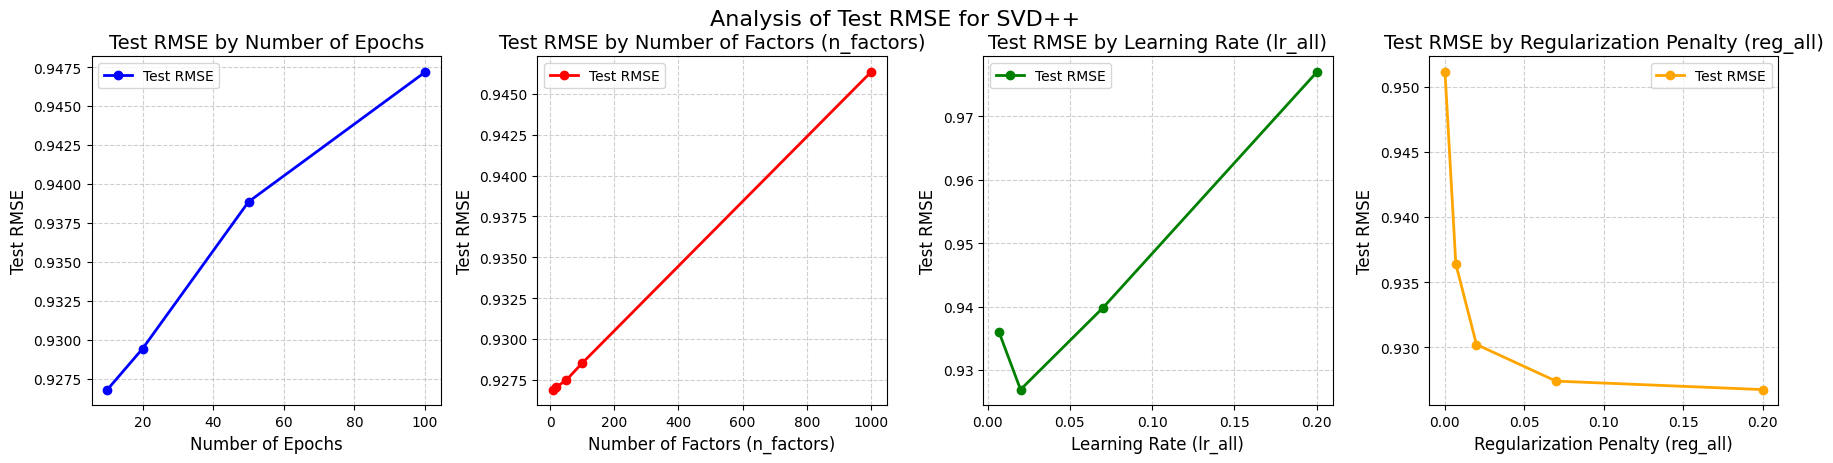

In [ ]:
import matplotlib.pyplot as plt

# Create a grid of subplots
fig, axes = plt.subplots(1, 4, figsize=(18, 4.5))

x1 = [10, 20, 50, 100]

# First plot
axes[0].plot(x1, rmse_list_n_epochs, label='Test RMSE', color='blue', marker='o', linewidth=2)
axes[0].set_title('Test RMSE by Number of Epochs', fontsize=14)
axes[0].set_xlabel('Number of Epochs', fontsize=12)
axes[0].set_ylabel('Test RMSE', fontsize=12)
axes[0].grid(True, linestyle='--', alpha=0.6)
axes[0].legend(fontsize=10)

x2 = [10, 20, 50, 100, 1000]

# Second plot
axes[1].plot(x2, rmse_list_n_factors, label='Test RMSE', color='red', marker='o', linewidth=2)
axes[1].set_title('Test RMSE by Number of Factors (n_factors)', fontsize=14)
axes[1].set_xlabel('Number of Factors (n_factors)', fontsize=12)
axes[1].set_ylabel('Test RMSE', fontsize=12)
axes[1].grid(True, linestyle='--', alpha=0.6)
axes[1].legend(fontsize=10)

x3 = [0.007, 0.02, 0.07, 0.2]

# Third plot
axes[2].plot(x3, rmse_list_lr_all, label='Test RMSE', color='green', marker='o', linewidth=2)
axes[2].set_title('Test RMSE by Learning Rate (lr_all)', fontsize=14)
axes[2].set_xlabel('Learning Rate (lr_all)', fontsize=12)
axes[2].set_ylabel('Test RMSE', fontsize=12)
axes[2].grid(True, linestyle='--', alpha=0.6)
axes[2].legend(fontsize=10)

x4 = [0.0002, 0.007, 0.02, 0.07, 0.2]

# Fourth plot
axes[3].plot(x4, rmse_list_reg_all, label='Test RMSE', color='orange', marker='o', linewidth=2)
axes[3].set_title('Test RMSE by Regularization Penalty (reg_all)', fontsize=14)
axes[3].set_xlabel('Regularization Penalty (reg_all)', fontsize=12)
axes[3].set_ylabel('Test RMSE', fontsize=12)
axes[3].grid(True, linestyle='--', alpha=0.6)
axes[3].legend(fontsize=10)

# Adjust layout
plt.tight_layout()

# Add a title for the entire figure
fig.suptitle('Analysis of Test RMSE for SVD++', fontsize=16, y=1.02)

plt.show()